In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph
import source.plot_helpers as plot

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
data = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(data))
data.head()

544


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
hlp.pandas.numeric_summary(data)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
height,544,0,0.0%,0,0.0%,138.3,27.6,0.2,-1.3,0.6,54.0,91.4,125.1,148.6,157.5,162.6,179.1
weight,544,0,0.0%,0,0.0%,35.6,14.7,0.4,-0.5,-0.9,4.2,12.5,22.0,40.1,47.2,51.6,63.0
age,544,0,0.0%,11,2.0%,29.3,20.8,0.7,0.5,-0.5,0.0,3.0,12.0,27.0,43.0,58.0,88.0
male,544,0,0.0%,287,53.0%,0.5,0.5,1.1,0.1,-2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


---

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, SplineTransformer, FunctionTransformer

def transform_is_adult(X):
    values = X[['age']].apply(lambda v: 1 if (v >= 18).all() else 0, axis=1).values
    return np.reshape(values, (-1, 1))

pipeline = make_column_transformer(
    (make_pipeline(StandardScaler(), SplineTransformer(n_knots=5, include_bias=False)), ['weight']),
    (FunctionTransformer(func=transform_is_adult), ['age']),
    ('passthrough', ['male']),
)

# pipeline = make_pipeline(
#     StandardScaler(),
#     make_column_transformer((PolynomialFeatures(3, include_bias=False), ['weight']))
# )

X = data.copy().drop(columns='height')
y = data['height']

print(X.head())
X = pipeline.fit_transform(X)
X.shape


      weight   age  male
0  47.825606  63.0     1
1  36.485807  63.0     0
2  31.864838  65.0     0
3  53.041914  41.0     1
4  41.276872  51.0     0


(544, 8)

In [5]:
print(data['age'].iloc[:20])
pd.DataFrame(X).head(20)

0     63.0
1     63.0
2     65.0
3     41.0
4     51.0
5     35.0
6     32.0
7     27.0
8     19.0
9     54.0
10    47.0
11    66.0
12    73.0
13    20.0
14    65.3
15    36.0
16    44.0
17    31.0
18    12.0
19     8.0
Name: age, dtype: float64


,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000006,0.183597,0.665607,1.507900e-01,1.0,1.0
1,0.000000,0.000000,0.086950,0.632356,0.279459,1.235445e-03,1.0,0.0
2,0.000000,0.000286,0.232818,0.653198,0.113698,0.000000e+00,1.0,0.0
3,0.000000,0.000000,0.000000,0.051854,0.579483,3.630780e-01,1.0,1.0
4,0.000000,0.000000,0.018290,0.465787,0.492321,2.360211e-02,1.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.166667,6.666667e-01,1.0,1.0
6,0.000000,0.000000,0.053647,0.583227,0.357933,5.193047e-03,1.0,0.0
7,0.000000,0.000000,0.000000,0.022315,0.486372,4.718945e-01,1.0,1.0
8,0.000000,0.000000,0.127701,0.659758,0.212439,1.021451e-04,1.0,0.0
9,0.000000,0.000000,0.000000,0.032376,0.526822,4.283793e-01,1.0,1.0


# Model - Poly

In [6]:
import pytensor.tensor as at

with pm.Model() as model_poly:
    # this is so we can update the data to make out of sample predictions
    X_ = pm.MutableData("X", X)
    y_ = pm.MutableData("y", y)

    a = pm.Normal("a", mu=178, sigma=100)
    # beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    beta = pm.Uniform("beta", lower = -200, upper=200, shape=X.shape[1])
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + at.dot(X_, beta))
    #mu = pm.Deterministic("mu", a + b1 * X[:, 0] + b2 * X[:, 1] + b3 * X[:, 2])
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=y_)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, beta, height, sigma]


# Prior Checks

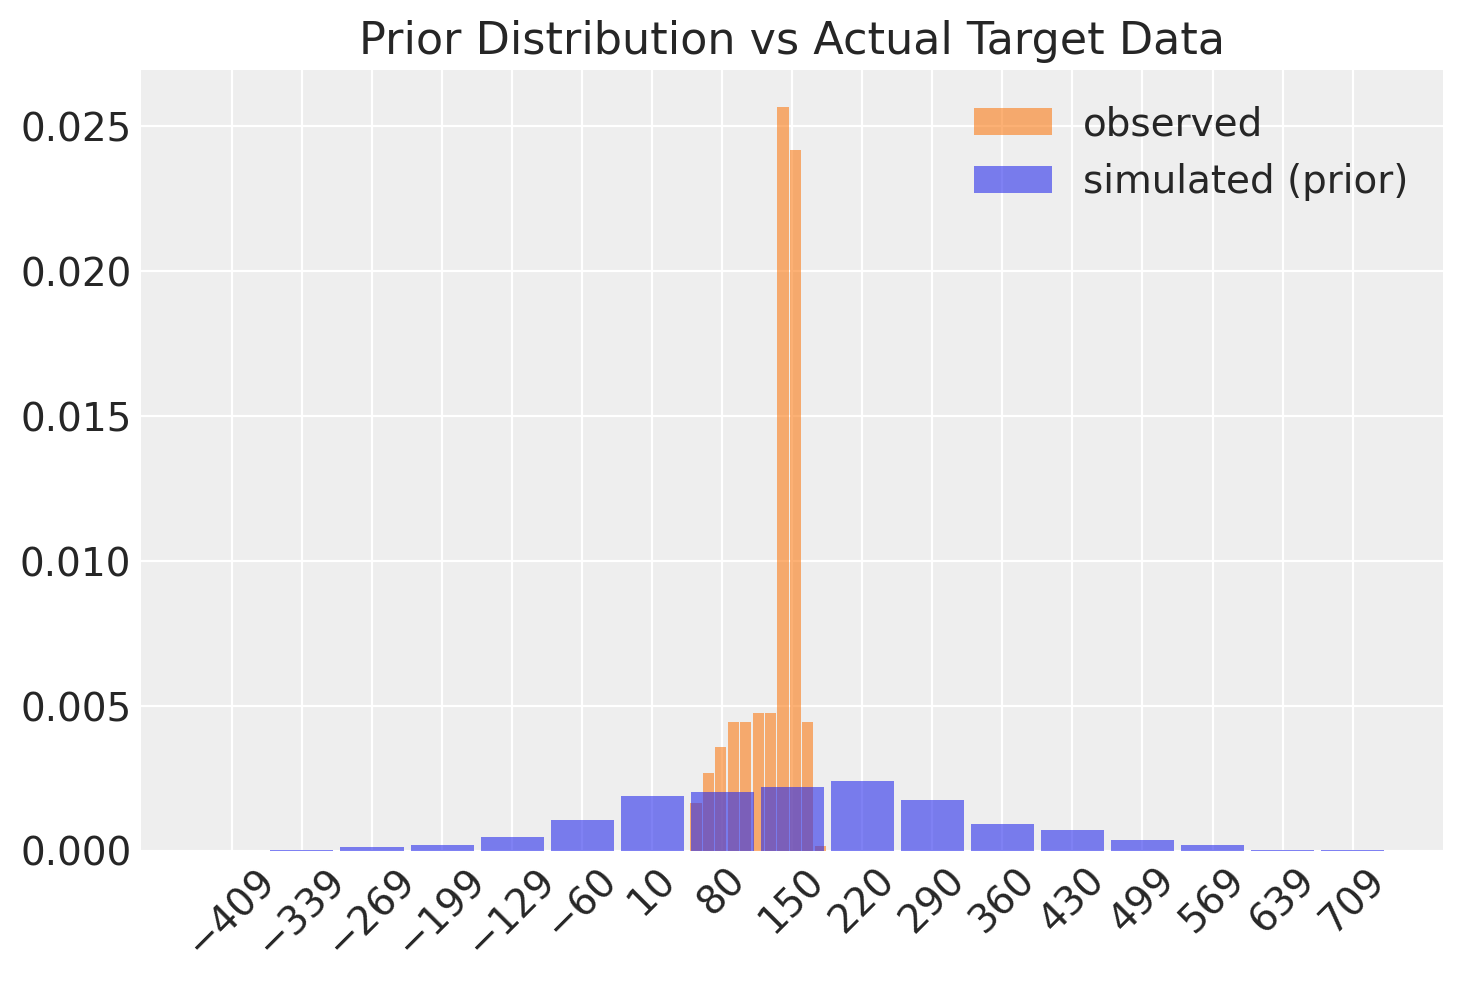

In [7]:
az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (prior)",
)
plt.xticks(rotation=45)
plt.title('Prior Distribution vs Actual Target Data');

# Posterior

In [8]:
with model_poly:
    # Train model
    idata_posterior = pm.sample(draws=1000, tune=1000)
    # Get samples from the posterior (predictions i.e. associated with the observed data)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [height]


## Model Parameters

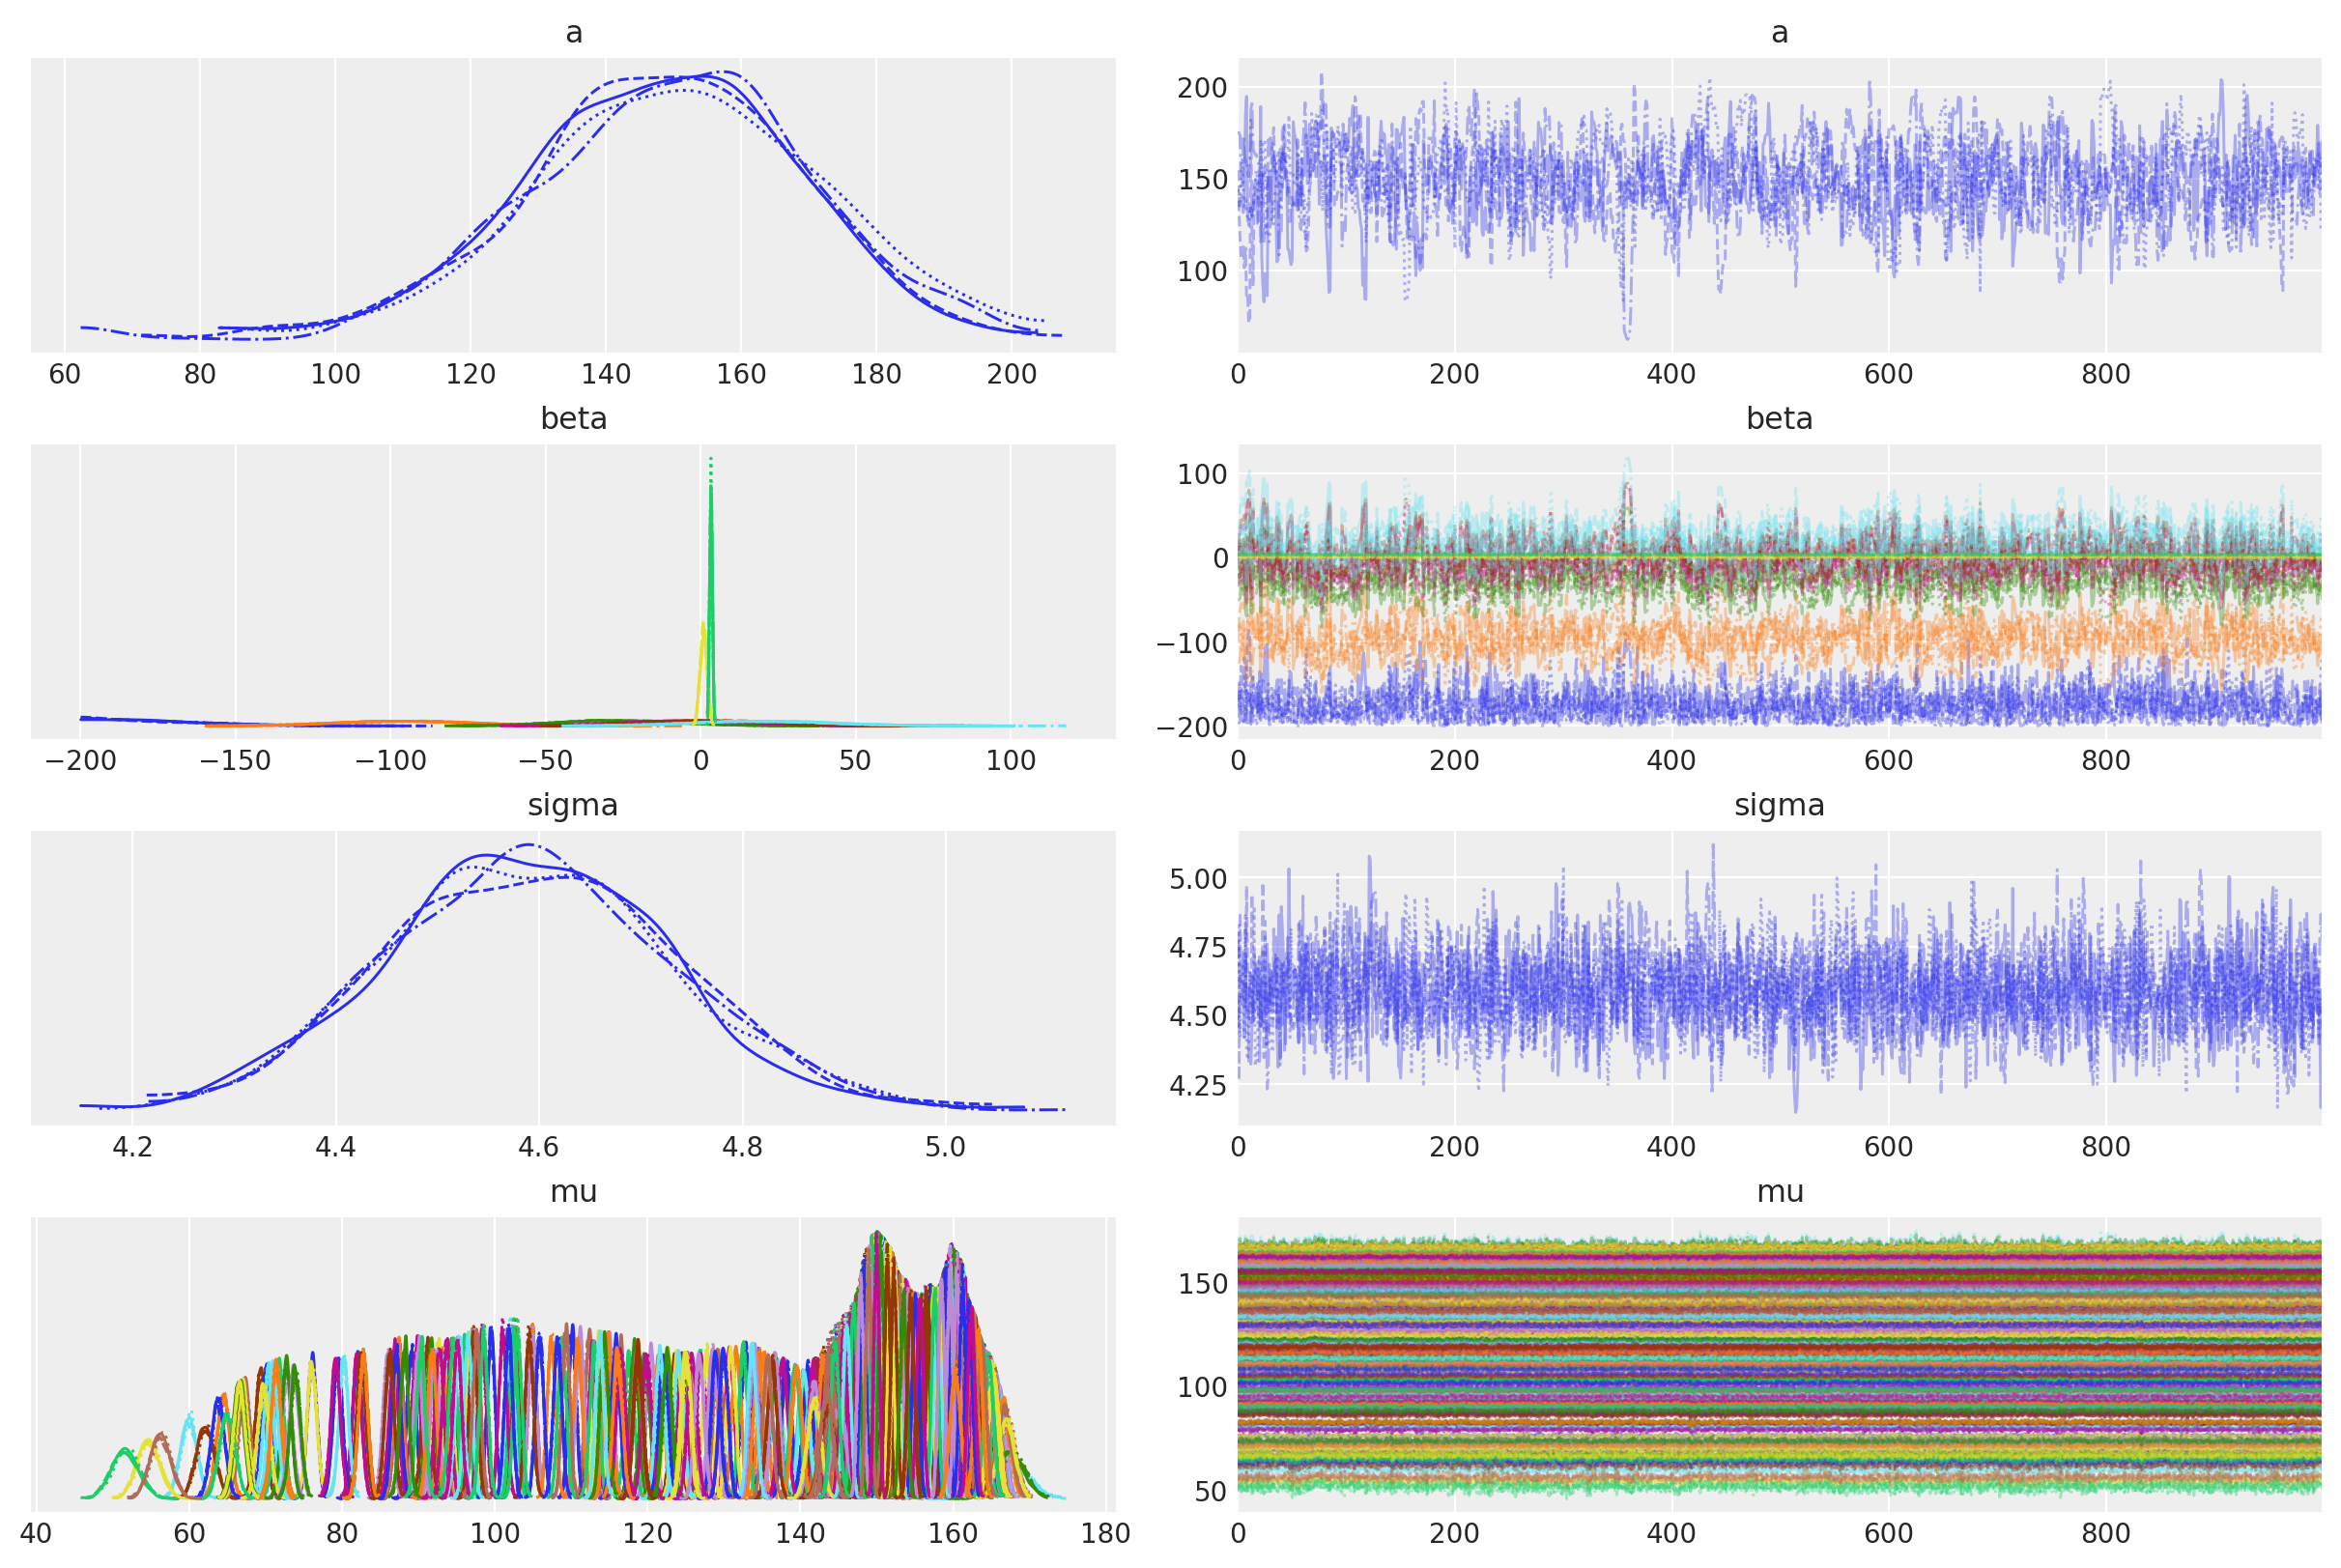

In [9]:
az.plot_trace(idata_posterior);

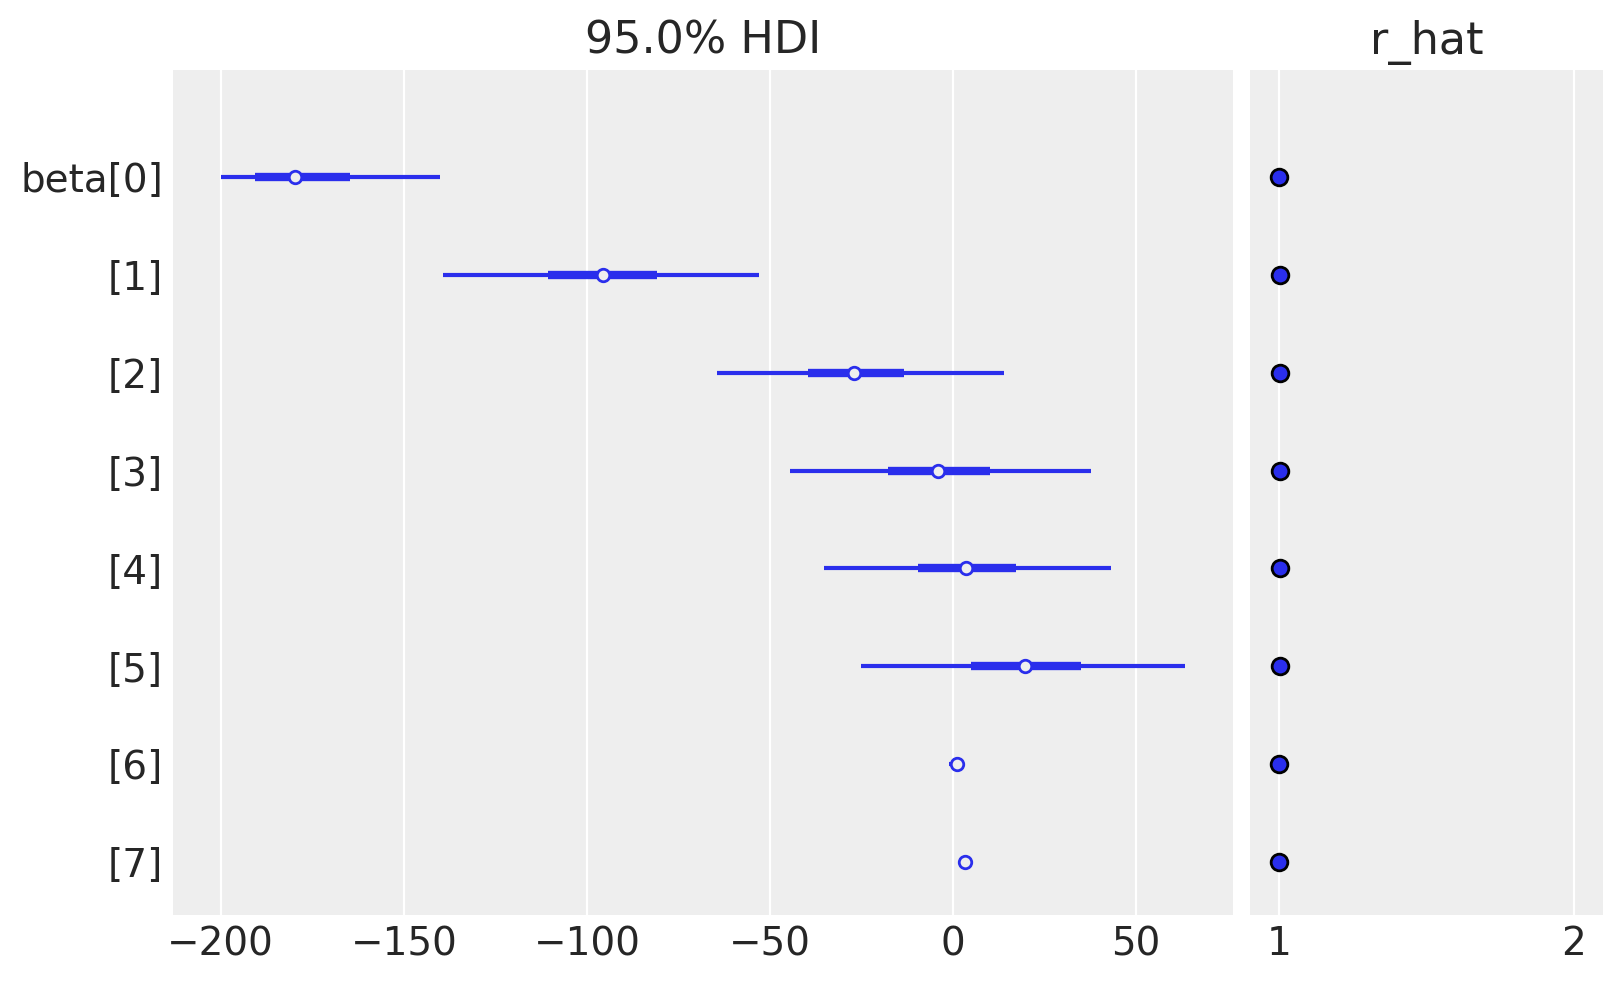

In [10]:
az.plot_forest(idata_posterior, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [11]:
az.summary(idata_posterior, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,148.946,20.615,110.331,187.492
beta[0],-175.782,18.678,-199.942,-143.705
beta[1],-95.447,22.198,-137.818,-55.428
beta[2],-26.107,19.983,-62.011,12.909
beta[3],-3.497,21.234,-42.323,36.971
...,...,...,...,...
mu[539],143.488,0.800,141.986,144.954
mu[540],162.065,0.444,161.258,162.920
mu[541],160.297,0.674,159.034,161.530
mu[542],73.897,0.696,72.605,75.244


### Comparison w/ `statsmodels` linear regression

In [12]:
import statsmodels.api as sm

ols_x = data.drop(columns='height')
ols_y = data['height']

ols_x = pipeline.transform(ols_x)

ols_x = sm.add_constant(ols_x)
ols_model = sm.OLS(ols_y, ols_x).fit() 
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2399.
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        22:00:23   Log-Likelihood:                -1595.2
No. Observations:                 544   AIC:                             3208.
Df Residuals:                     535   BIC:                             3247.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.0638     26.117      6.243      0.0

In [31]:
import plotly_express as px

ols_predictions = ols_model.predict(ols_x)
temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights (OLS)"] = ols_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights (OLS)",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title=plot.px_title(
        "Actual vs Prediction (OLS)",
        "red line is perfect fit; blue line is actual fit"
    )
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0])
fig


---

## Target Variable

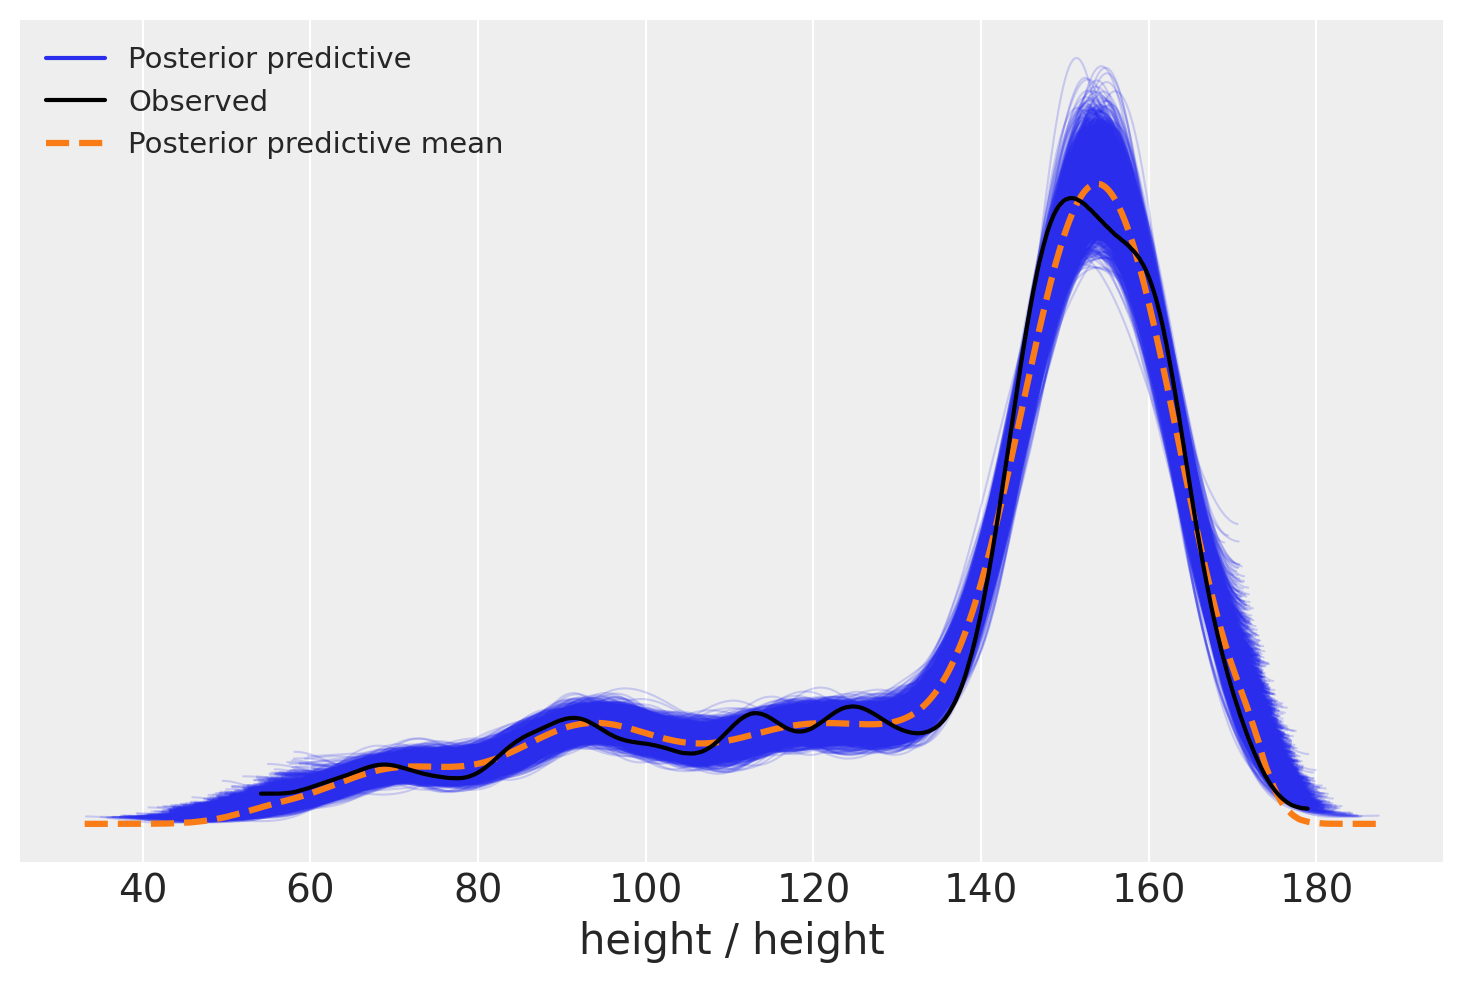

In [14]:
az.plot_ppc(idata_predictive);

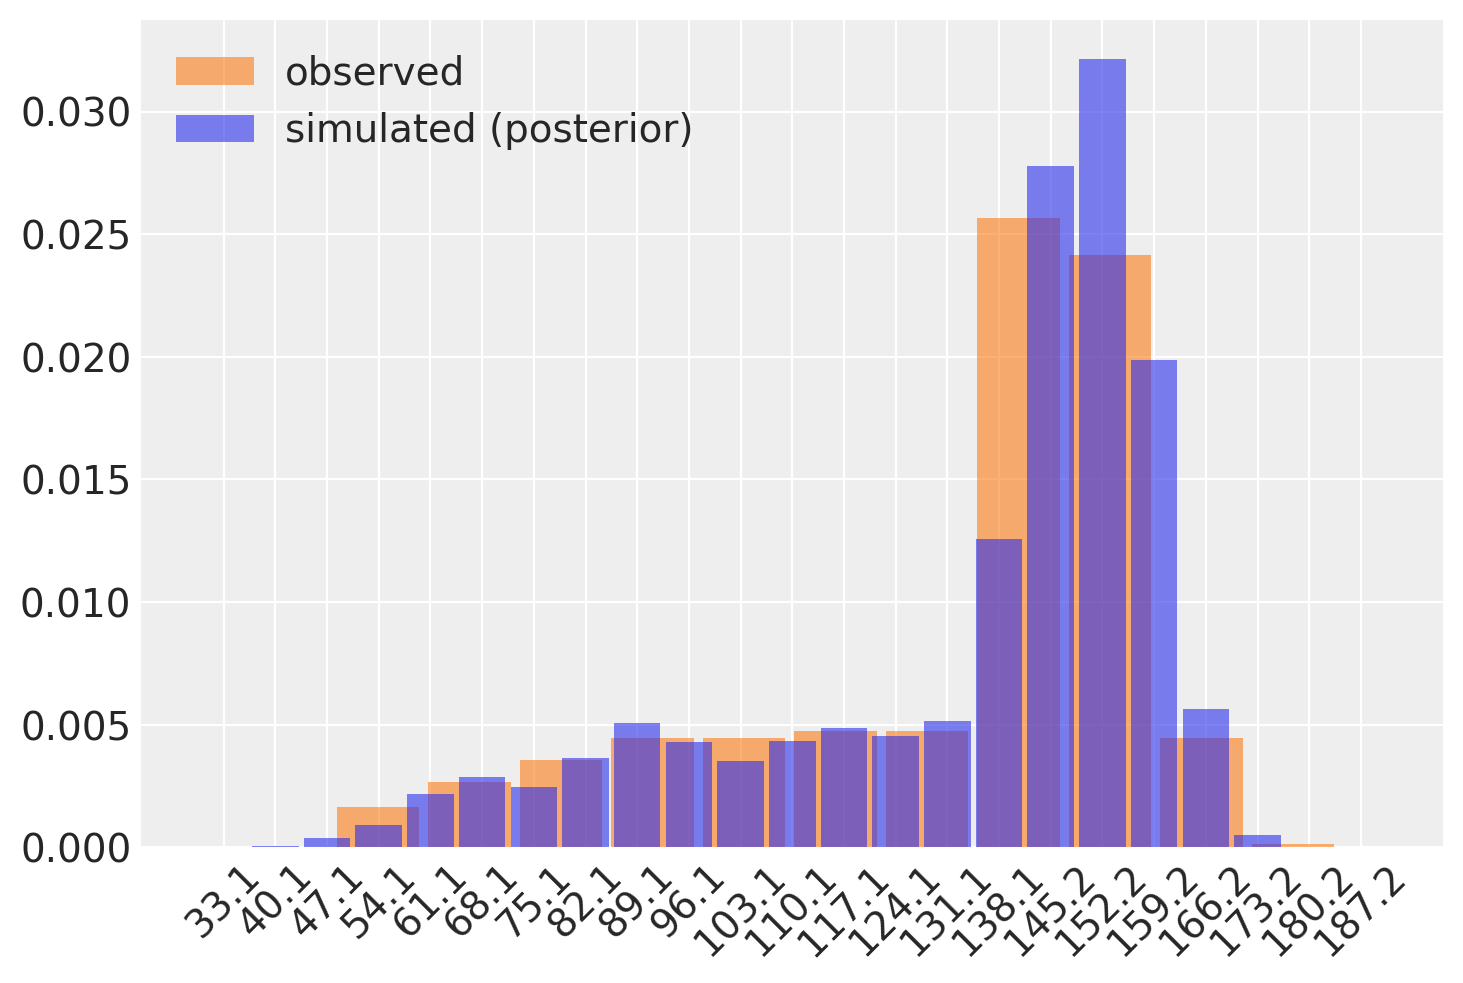

In [15]:

az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_predictive.posterior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (posterior)",
)
plt.xticks(rotation=45);

In [16]:
prediction_simulations = ph.get_posterior_samples(idata_predictive)
prediction_simulations.shape

(544, 4000)

In [17]:
print(prediction_simulations.min().min())
print(prediction_simulations.max().max())

33.08195872399098
187.55434069760793


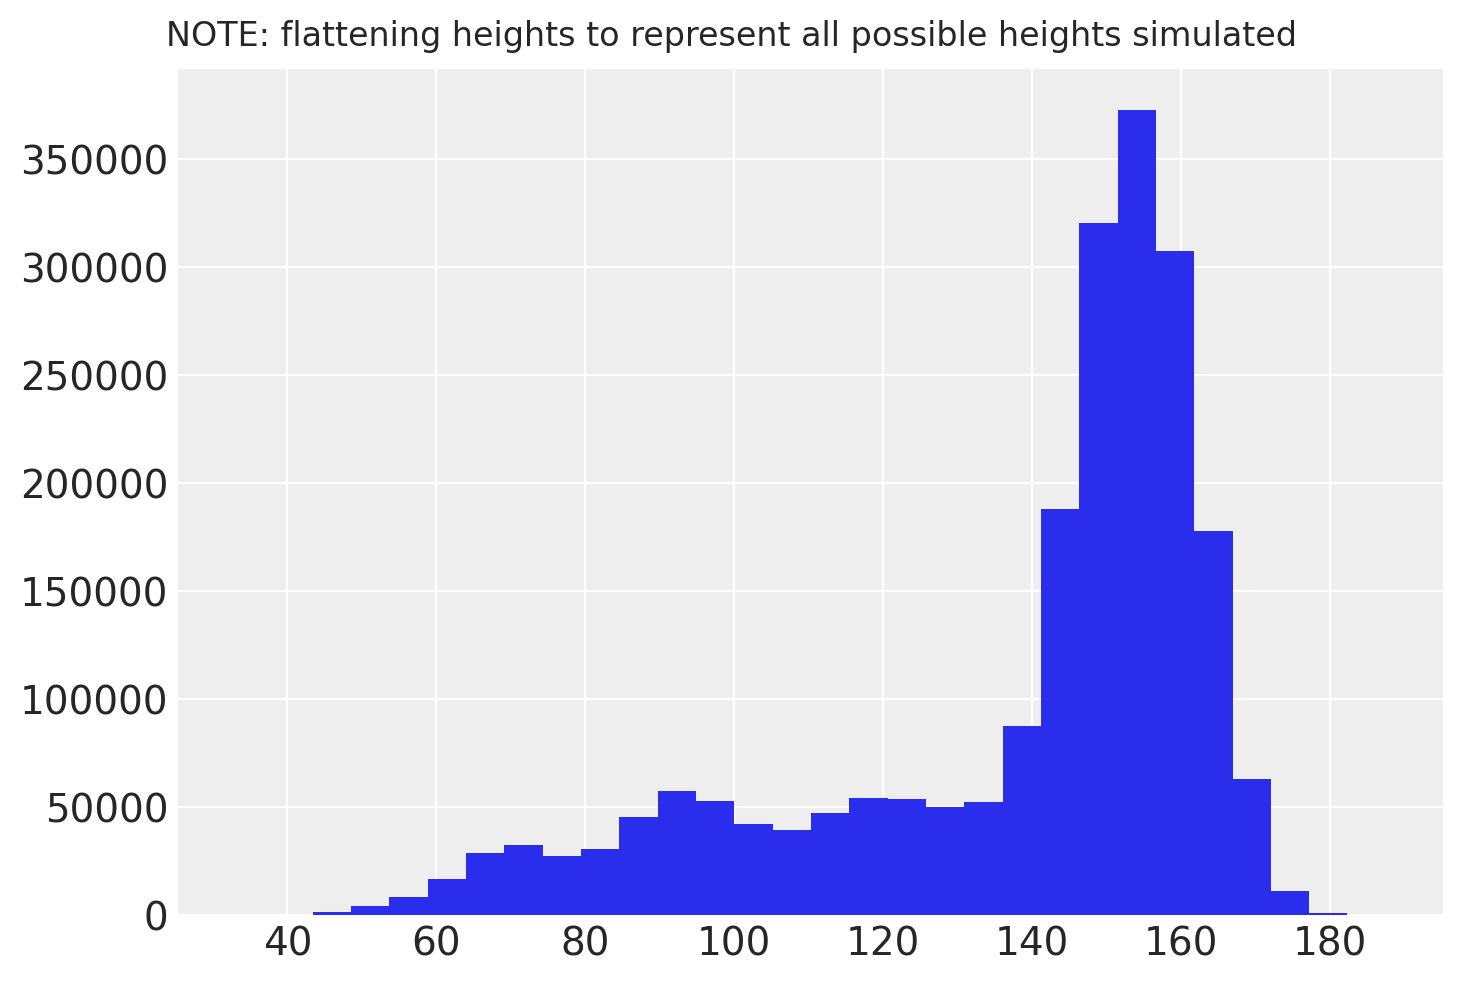

In [18]:
plt.hist(prediction_simulations.flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

Each height is associated with `4000` simulated values. Now get the median/expected value and plot histogram of median values just to see the difference.

In [19]:
print(np.median(prediction_simulations, axis=1).min())
print(np.median(prediction_simulations, axis=1).max())

51.648765610831305
167.40867264618925


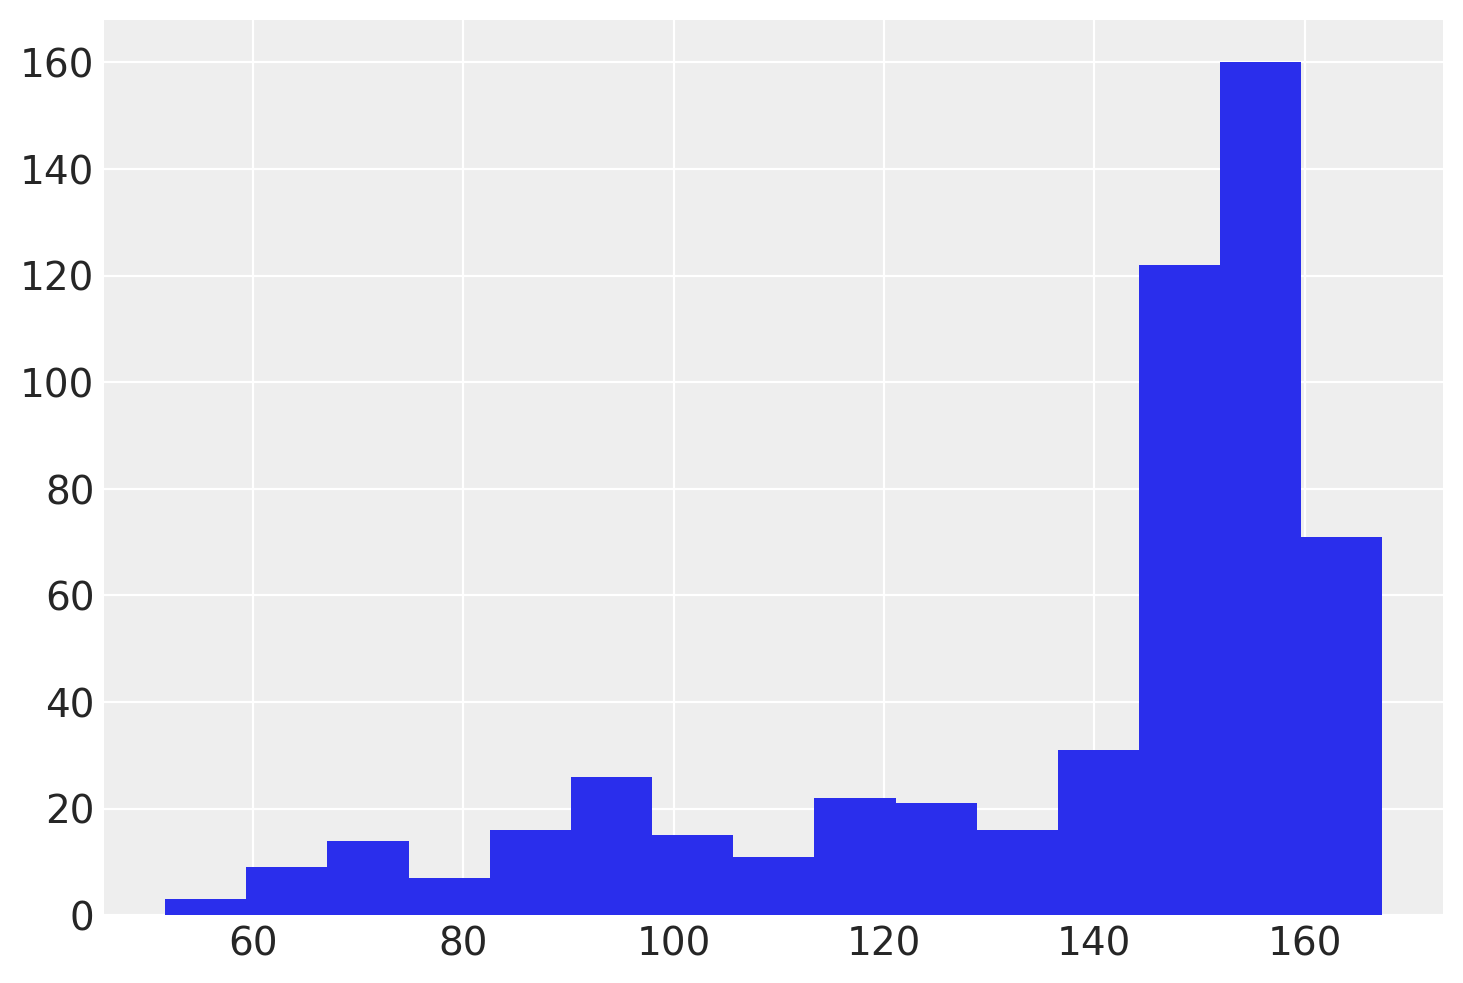

In [20]:
plt.hist(np.median(prediction_simulations, axis=1), bins=15);

In [21]:
az.summary(idata_posterior, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,148.946,20.615,110.331,187.492
beta[0],-175.782,18.678,-199.942,-143.705
beta[1],-95.447,22.198,-137.818,-55.428
beta[2],-26.107,19.983,-62.011,12.909
beta[3],-3.497,21.234,-42.323,36.971
...,...,...,...,...
mu[539],143.488,0.800,141.986,144.954
mu[540],162.065,0.444,161.258,162.920
mu[541],160.297,0.674,159.034,161.530
mu[542],73.897,0.696,72.605,75.244


In [22]:
az.summary(idata_predictive, kind="stats")

/usr/local/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning:

Selecting first found group: posterior_predictive



,mean,sd,hdi_3%,hdi_97%
height[0],158.498,4.599,150.019,167.259
height[1],146.783,4.478,138.352,155.272
height[2],141.822,4.531,133.867,150.795
height[3],162.812,4.703,154.069,171.553
height[4],150.271,4.616,141.664,158.746
...,...,...,...,...
height[539],143.554,4.733,134.385,152.188
height[540],162.016,4.569,153.901,171.138
height[541],160.353,4.610,151.771,169.018
height[542],73.926,4.595,65.789,83.020


In [23]:
posterior_target_samples = ph.get_posterior_samples(idata_predictive)
posterior_target_point_predictions = np.median(posterior_target_samples, axis=1)
assert posterior_target_samples.shape[0] == len(posterior_target_point_predictions)

(30.0, 195.0)

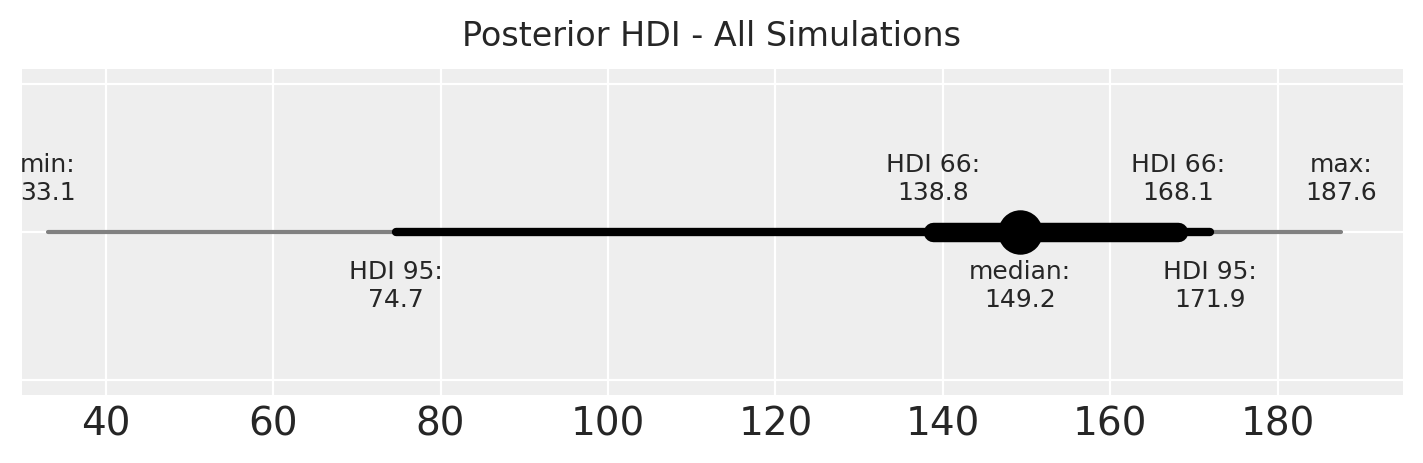

In [32]:
from helpsk.string import format_number

samples_flattened = posterior_target_samples.flatten()
plot.plot_hdi(
    samples_flattened,
    #vertical_factor_66=2, vertical_factor_95=2,
    title="Posterior HDI - All Simulations"
)
plt.xlim((30, 195))

(30.0, 195.0)

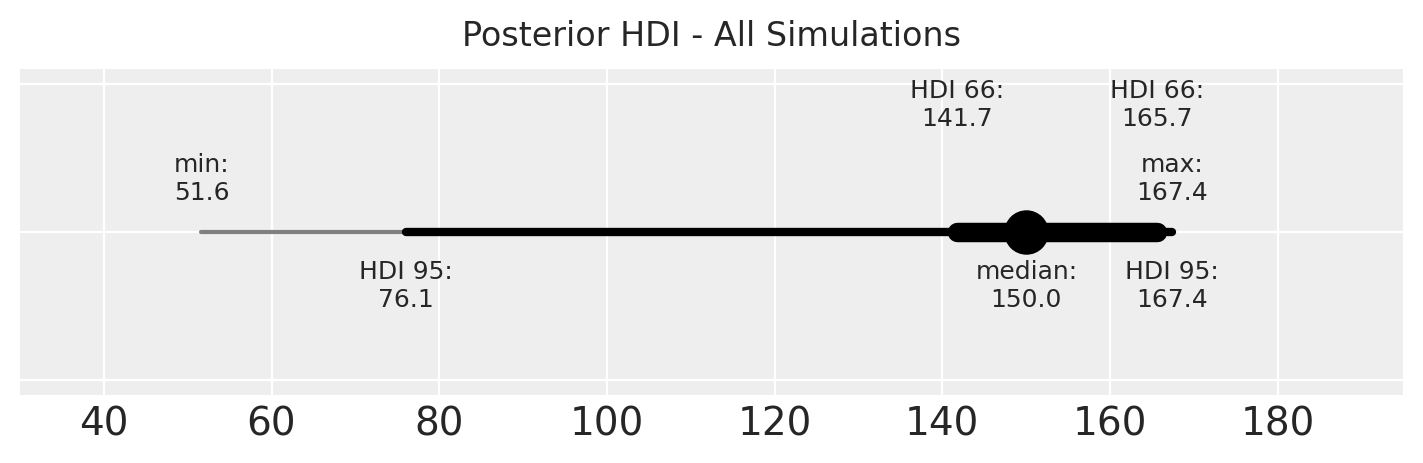

In [33]:
from helpsk.string import format_number

plot.plot_hdi(
    posterior_target_point_predictions,
    vertical_factor_66=2,
    title="Posterior HDI - All Simulations"
)
plt.xlim((30, 195))

## Actual vs Predicted

In [35]:
import plotly_express as px

temp = data.copy()
temp.rename(columns={'height': 'Actual Heights'}, inplace=True)
temp['Predicted Heights'] = posterior_target_point_predictions
temp['Residuals'] = temp['Predicted Heights'] - temp['Actual Heights']

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title=plot.px_title(
        "Actual vs Prediction (OLS)",
        "red line is perfect fit; blue line is actual fit"
    )
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0])
fig


## Residuals

In [27]:
temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Residuals"] = posterior_target_point_predictions - temp['Actual Heights']

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Residuals",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Residual (Predicted - Actual)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)
fig.add_hline(y=0, line_width=3, line_color="red")
fig


In [36]:
fig = px.histogram(
    temp,
    x="Residuals",
    title=plot.px_title(
        "Residuals (Predicted - Actual)",
        "red line is perfect fit"
    )
)
fig.add_vline(x=0, line_width=3, line_color="red")
fig


---

# New Predictions

In [29]:
new_data = pd.DataFrame(dict(
    weight=[10, 20, 30, 40],
    age=[10, 20, 30, 40],
    male=[1, 0, 0, 0],
))
new_data = pipeline.transform(new_data)
print(new_data)
prediction_sims = ph.posterior_predict(
    model=model_poly,
    idata_posterior=idata_posterior,
    data=new_data
)
prediction_sims

Sampling: [height]


[[3.75721863e-02 5.43458415e-01 4.08976829e-01 9.99257003e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.33043720e-01 6.61620839e-01 2.05272309e-01
  6.31323226e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.50179062e-03 3.12926861e-01 6.13320980e-01
  7.12503685e-02 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.01746219e-02 5.19017034e-01
  4.37157069e-01 1.36512755e-02 1.00000000e+00 0.00000000e+00]]


array([[ 77.49773648,  90.67555567,  86.83297222, ...,  89.09517524,
         85.97837122,  82.69360971],
       [119.74867521, 119.60072559, 121.05931796, ..., 125.54131535,
        120.43589528, 118.67928494],
       [135.66236978, 144.87692751, 132.72515582, ..., 137.31273494,
        141.65538714, 146.51640761],
       [149.62949378, 150.94644386, 148.95380379, ..., 150.54131715,
        150.23414374, 147.89133834]])

In [30]:
np.median(prediction_sims, axis=1)

array([ 83.03683533, 119.10148396, 139.60697103, 149.41032957])

---